In [178]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import bs4
import lxml
import csv
from rotten_tomatoes_scraper.rt_scraper import MovieScraper
%matplotlib inline

In [7]:
bom_gross    = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
the_numbers  = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
rt_info      = pd.read_csv('../zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='iso8859_1')
rt_reviews   = pd.read_csv('../zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='iso8859_1')
# data_imdbr = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
# data_imdbb = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
# data_imdbn = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
# data_imdbc = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
# data_imdbp = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
# data_imdba = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
# data_tmdb  = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [190]:
bom_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


# Box Office Mojo

## Clean for studio grouping.
In the cells below, the data is being cleaned for empty cells in studio and summing the total grossing amount to total domestic and foreign.

clean out empty rown in studio column and set to new variable.

Adding the foreing and domestic gross to total_gross column.

In [9]:
bom_clean = bom_gross[bom_gross['studio'].notna()]

In [10]:
bom_clean['foreign_gross'] = bom_clean['foreign_gross'].str.replace(',','').astype(float)

<ipython-input-10-9d1896d0b027>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bom_clean['foreign_gross'] = bom_clean['foreign_gross'].str.replace(',','').astype(float)


In [11]:
bom_clean['total_gross'] = bom_clean.fillna(0)['domestic_gross'] + bom_clean.fillna(0)['foreign_gross']

<ipython-input-11-2e853af365ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bom_clean['total_gross'] = bom_clean.fillna(0)['domestic_gross'] + bom_clean.fillna(0)['foreign_gross']


Dropping the domestic and foreign columns 

In [12]:
bom_clean.drop('domestic_gross',axis=1,inplace=True)
bom_clean.drop('foreign_gross',axis=1,inplace=True)


C:\Users\ajche\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
bom_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        3382 non-null   object 
 1   studio       3382 non-null   object 
 2   year         3382 non-null   int64  
 3   total_gross  3382 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 132.1+ KB


In [14]:
title_counts = bom_clean['title'].value_counts() > 1

In [15]:
title_counts[title_counts.values == True]

Bluebeard    True
Name: title, dtype: bool

In [16]:
bom_clean[bom_clean['title'] == 'Bluebeard']

,title,studio,year,total_gross
317,Bluebeard,Strand,2010,38700.0
3045,Bluebeard,WGUSA,2017,43100.0


In [17]:
bom_clean[(bom_clean['title'] == 'Bluebeard') & (bom_clean['year'] == 2010)]['title'].replace('Bluebeard','Bluebeard2010',inplace=True)

C:\Users\ajche\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Setting Cleaned data in new variable.

In [18]:
bom_top1k_gross = bom_clean.sort_values('total_gross',ascending=False).head(1000)

## Exploratory Data Analysis

### Making a plot of the movie count per production company of the top 1000 grossing movies

<BarContainer object of 65 artists>

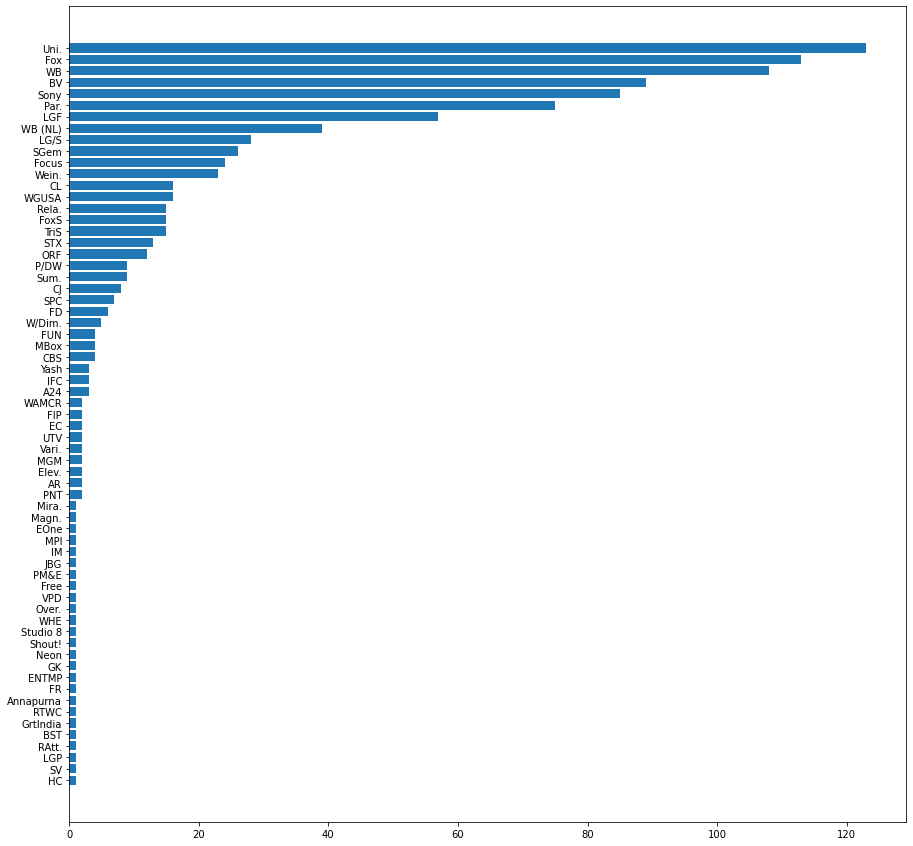

In [19]:
fig , ax = plt.subplots(figsize=(15,15))
ax.barh(bom_top1k_gross['studio'].value_counts().sort_values(ascending=True).index,bom_top1k_gross['studio'].value_counts().sort_values(ascending=True).values)

Out of the top 1000 grossing movies in the data set, this is a bar graph showing the number of movies by production company. The big players in the film industry in terms of sheer numbers are universal, Fax, warner brothers, Walt Disney, Soney, Paramount, and Lionsgate

ISSUES: Looks like warner brothers had two separate tags, need to look into movie titles to figure out what is going ofn with that.

IFC: IFC Films
Uni.: Universal
WB: Warner Brothers
Magn.: Magnolia Studios
Fox: Fox
SPC: Sony Pictures Classics
Sony: Sony Productions
BV: Disney
LGF: Lionsgate
Par.: Paramount
Eros: Eros International Media Ltd. (India Studio)
Wein.: The Weinstein Company
CL: ?
Strand: Strand Studios(Animated Movies)
FoxS: part of The Walt Disney Company (India)


# Rotten Tomatoes

## Data Cleaning

In [103]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54432 entries, 3 to 2000
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      48869 non-null  object
 1   rating      40915 non-null  object
 2   fresh       54432 non-null  object
 3   critic      51710 non-null  object
 4   top_critic  54432 non-null  int64 
 5   publisher   54123 non-null  object
 6   date        54432 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.6+ MB


In [192]:
rt_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552 entries, 1 to 2000
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   synopsis      1495 non-null   object
 1   rating        1552 non-null   object
 2   genre         1552 non-null   object
 3   director      1360 non-null   object
 4   writer        1110 non-null   object
 5   theater_date  1201 non-null   object
 6   dvd_date      1201 non-null   object
 7   currency      340 non-null    object
 8   box_office    340 non-null    object
 9   runtime       1526 non-null   object
 10  studio        494 non-null    object
dtypes: object(11)
memory usage: 145.5+ KB


In [212]:
rt_info.dropna(subset=['genre'],inplace=True)
rt_info.reset_index(inplace=True)

# The Numbers


## Data Cleaning

In [24]:
the_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [27]:
the_numbers.set_index('id',inplace=True)

In [61]:
the_numbers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   float64       
 3   domestic_gross     5782 non-null   float64       
 4   worldwide_gross    5782 non-null   float64       
 5   year               5782 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 476.2+ KB


In [42]:
the_numbers['release_date'] = pd.DatetimeIndex(the_numbers['release_date'])

In [56]:
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].str.replace(',','')
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].str.replace('$','')
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].astype(float)

In [59]:
the_numbers['production_budget'] = the_numbers['production_budget'].str.replace(',','')
the_numbers['production_budget'] = the_numbers['production_budget'].str.replace('$','')
the_numbers['production_budget'] = the_numbers['production_budget'].astype(float)

In [60]:
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].str.replace(',','')
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].str.replace('$','')
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].astype(float)

In [63]:
the_numbers.sort_values('worldwide_gross',ascending=False).head(10)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
id,,,,,,
1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009
43,1997-12-19,Titanic,200000000.0,659363944.0,2.208208e+09,1997
6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,2015
7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018
34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,2015
67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,2015
27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,2012
4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015
42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09,2018


In [70]:
the_numbers_clean = the_numbers[(the_numbers['production_budget'] > 0) &\
     (the_numbers['domestic_gross'] > 0) &\
          (the_numbers['worldwide_gross'] > 0)]

In [72]:
the_numbers_clean['net'] = -the_numbers_clean['production_budget'] +\
     the_numbers_clean['domestic_gross'] +\
          the_numbers_clean['worldwide_gross']

<ipython-input-72-d501672c45a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_numbers_clean['net'] = -the_numbers_clean['production_budget'] +\


<AxesSubplot:ylabel='Frequency'>

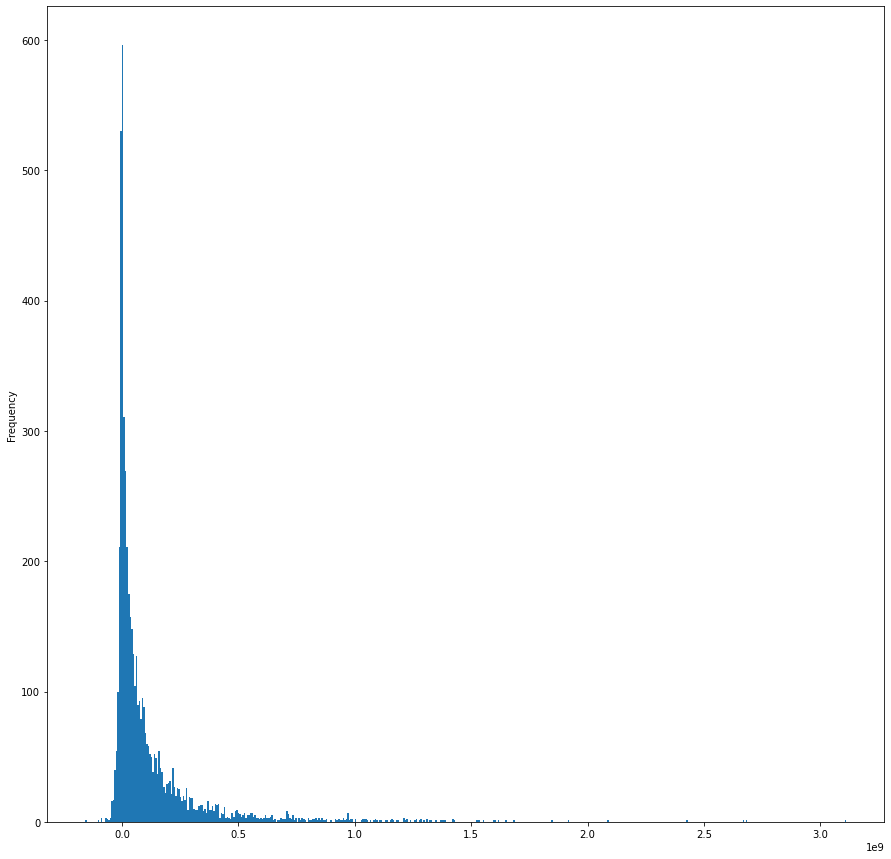

In [86]:
the_numbers_clean['net'].plot(kind='hist',figsize=(15,15),bins=500)
the_numbers_clean[]